In [204]:
%config InlineBackend.figure_format = "svg"
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Preprocessing

In [244]:
df = pd.read_csv("/home/gilbertocunha/Desktop/buckets.csv")
columns = {"Parallel": "Bucket Parallel"}
df.rename(columns=columns, inplace=True)
df["Union Parallel"] = df["Cutoff"] == 420
df.loc[(df["Thread Count"]==1) & (df["Bucket Parallel"]==0), "Thread Count"] = "Any"
df.drop(columns=["Sort Function", "Cutoff"], inplace=True)
df

,Total Size,Number of Buckets,Thread Count,Bucket Parallel,I,CC,Texe,CPI,Union Parallel
0,10000000,40,40,1,448439072.0,447885664.0,282674.0,0.998766,True
1,10000000,40,40,1,470831840.0,540972032.0,259881.0,1.148971,True
2,10000000,40,40,1,483388320.0,555850432.0,264713.0,1.149905,True
3,10000000,40,40,1,469475072.0,516706880.0,278858.0,1.100606,True
4,10000000,40,40,1,472295008.0,518144800.0,249603.0,1.097079,True
...,...,...,...,...,...,...,...,...,...
3395,10000000,1000,40,1,417097856.0,748786048.0,1054127.0,1.795229,False
3396,10000000,1000,40,1,412562496.0,735810368.0,1082065.0,1.783512,False
3397,10000000,1000,40,1,419542464.0,755066240.0,1052376.0,1.799737,False
3398,10000000,1000,40,1,413166176.0,737482368.0,1119382.0,1.784953,False


# Plotting

In [247]:
def get_means_stds(x, y, num_runs=50):
    assert len(y) % num_runs == 0, print("Number of runs is incorrect")
    
    new_x, y_means, y_stds = [], [], []
    for i in range(int(len(y)/num_runs)):
        new_x.append(x[num_runs*i])
        y_means.append(y[num_runs*i:num_runs*(i+1)].mean())
        y_stds.append(y[num_runs*i:num_runs*(i+1)].std())
    
    new_x = np.array(new_x, dtype=float)
    y_means = np.array(y_means, dtype=float)
    y_stds = np.array(y_stds, dtype=float)
    
    return new_x, y_means, y_stds

def plot(ax, x, y_mean, y_std, cf, label, option, linestyle="-", marker="o", color="blue"):
    ax.plot(x, y_mean, label=label, linestyle=linestyle, color=color)
    if label != "Ideal gain": ax.scatter(x, y_mean, marker=marker, color=color)
    ax.fill_between(x, y_mean - cf * y_std, y_mean + cf * y_std, alpha=0.2, color=color)
    
def Max(x):
    if x.size > 0:
        r = max(x)
    else:
        r = float("-inf")
    return r

def Min(x):
    if x.size > 0:
        r = min(x)
    else:
        r = float("Inf")
    return r

def plot_df_slice (df, x, y, filter_dict, num_runs=100, conf_interval=5, num_ticks=10, yscale="linear", xscale="linear", filename="plot.png", option="None"):
    # Filter dataframe copy
    config = ""
    df_cpy = df
    for i, key in enumerate(filter_dict):
        if key == "Thread Count":
            df_cpy.loc[df_cpy[key]=="Any", key] = filter_dict[key]
        config += f"{key}={filter_dict[key]}\n"
        df_cpy = df_cpy[df_cpy[key] == filter_dict[key]]
    config += f"Confidence Interval=${conf_interval} \cdot \sigma$"
    
    # Get Parallel Quicksort x and y data
    x_p = df_cpy[(df_cpy["Bucket Parallel"]==1) & (df_cpy["Union Parallel"]==False)][x].to_numpy()
    y_p = df_cpy[(df_cpy["Bucket Parallel"]==1) & (df_cpy["Union Parallel"]==False)][y].to_numpy()
    x_p, y_p_mean, y_p_std = get_means_stds(x_p, y_p, num_runs)
    
    # Get Parallel Quicksort Parallel Union x and y data
    x_pp = df_cpy[(df_cpy["Bucket Parallel"]==1) & (df_cpy["Union Parallel"]==True)][x].to_numpy()
    y_pp = df_cpy[(df_cpy["Bucket Parallel"]==1) & (df_cpy["Union Parallel"]==True)][y].to_numpy()
    x_pp, y_pp_mean, y_pp_std = get_means_stds(x_pp, y_pp, num_runs)
    
    # Get Quicksort x and y data
    x_s = df_cpy[(df_cpy["Bucket Parallel"]==0) & (df_cpy["Union Parallel"]==False)][x].to_numpy()
    y_s = df_cpy[(df_cpy["Bucket Parallel"]==0) & (df_cpy["Union Parallel"]==False)][y].to_numpy()
    if x != "Thread Count":
        x_s, y_s_mean, y_s_std = get_means_stds(x_s, y_s, num_runs)
    
    # Gains
    if option in ["Gain", "Parallel Fraction"]:
        if option == "Gain": y = "Gain " + y
        else: y = "Parallel Fraction (%)"
        if len(x_p) > 0:
            y_p_std[:] = np.sqrt((y_p_std[0]/y_p_mean[:])**2 + (y_p_mean[0] * y_p_std[:] / (y_p_mean[:]**2))**2)
            y_p_mean[:] = y_p_mean[0] / y_p_mean[:]
            if option == "Parallel Fraction":
                indices = np.where(x_p==1)
                y_p_mean = np.delete(y_p_mean, indices)
                y_p_std = np.delete(y_p_std, indices)
                x_p = np.delete(x_p, indices)
                y_p_std[:] = 100 * np.abs(x_p[:] / (y_p_mean[:]**2 * (1 - x_p[:])) * y_p_std[:])
                y_p_mean[:] = 100 * x_p[:] / (1 - x_p[:]) * ((1/y_p_mean[:]) - 1)
        if len(x_s) > 0 and x!="Thread Count":
            y_s_std[:] = np.sqrt((y_s_std[0]/y_s_mean[:])**2 + (y_s_mean[0] * y_s_std[:] / (y_s_mean[:]**2))**2)
            y_s_mean[:] = y_s_mean[0] / y_s_mean[:]
            if option == "Parallel Fraction":
                indices = np.where(x_s==1)
                y_s_mean = np.delete(y_s_mean, indices)
                y_s_std = np.delete(y_s_std, indices)
                x_s = np.delete(x_s, indices)
                y_s_std[:] = 100 * np.abs(x_s[:] / (y_s_mean[:]**2 * (1 - x_s[:])) * y_s_std[:])
                y_s_mean[:] = 100 * x_s[:] / (1 - x_s[:]) * ((1/y_s_mean[:]) - 1)
        if len(x_pp) > 0:
            y_pp_std[:] = np.sqrt((y_pp_std[0]/y_pp_mean[:])**2 + (y_pp_mean[0] * y_pp_std[:] / (y_pp_mean[:]**2))**2)
            y_pp_mean[:] = y_pp_mean[0] / y_pp_mean[:]
            if option == "Parallel Fraction":
                indices = np.where(x_pp==1)
                y_pp_mean = np.delete(y_pp_mean, indices)
                y_pp_std = np.delete(y_pp_std, indices)
                x_pp = np.delete(x_pp, indices)
                y_pp_std[:] = 100 * np.abs(x_pp[:] / (y_pp_mean[:]**2 * (1 - x_pp[:])) * y_pp_std[:])
                y_pp_mean[:] = 100 * x_pp[:] / (1 - x_pp[:]) * ((1/y_pp_mean[:]) - 1)
    
    # Plot with matplotlib
    fig, ax = plt.subplots(figsize=(12, 6))
    if option == "Gain": plot(ax, x_p, x_p, [0 for _ in x_p], 1, label="Ideal gain", linestyle="--", option=option, color="red")
    if len(x_p) > 0: plot(ax, x_p, y_p_mean, y_p_std, conf_interval, label="PB", option=option, color="blue")
    if len(x_pp) > 0: plot(ax, x_pp, y_pp_mean, y_pp_std, conf_interval, label="PBPU", option=option, marker="x", color="green")
    if len(x_s) > 0 and x!="Thread Count": plot(ax, x_s, y_s_mean, y_s_std, conf_interval, label="SB", option=option, marker="s", color="orange")
    
    # Additional plot settings
    props = dict(boxstyle='square', facecolor='white')
    ax.text(0.0125, 1.025, config, transform=ax.transAxes, fontsize=10, bbox=props)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_yscale(yscale)
    ax.set_xscale(xscale)
    plt.minorticks_on()
    ax.grid(b=True, which="major", linestyle="-")
    ax.grid(b=True, which="minor", linestyle="--")
    plt.legend()
    plt.savefig(filename, dpi=300, bbox_inches="tight", pad_inches=0.2)
    plt.show()

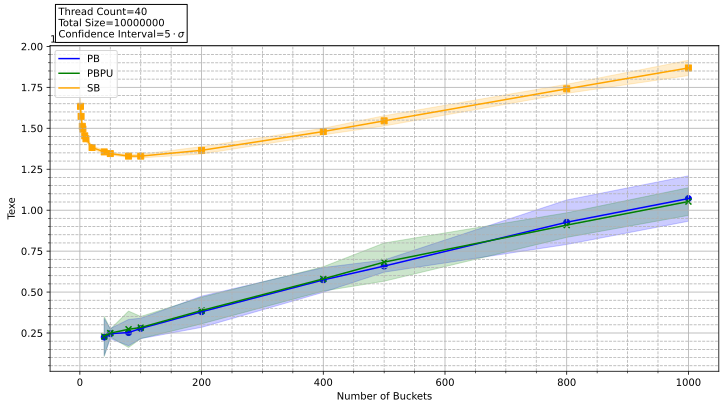

In [249]:
filter_dict = {
    "Thread Count": 40,
    "Total Size": 10000000
}

plot_df_slice(df, x="Number of Buckets", y="Texe", filter_dict=filter_dict, conf_interval=5, num_ticks=5, yscale="linear", xscale="linear", filename="Plots/BucketsVM", option="None")

In [208]:
def amdahl_gain(p, s):
    return 1 / ((1-p) + p/s)

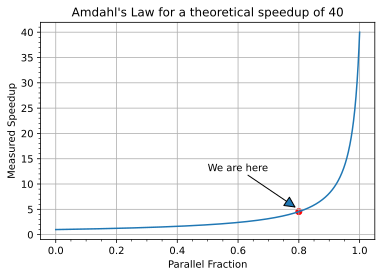

In [209]:
x = np.linspace(0, 1, 1000)
y = [amdahl_gain(xs, 40) for xs in x]

prop = dict(arrowstyle="-|>,head_width=0.5,head_length=1",
            shrinkA=0,shrinkB=0)

plt.title("Amdahl's Law for a theoretical speedup of 40")
plt.plot(x, y)
plt.scatter(0.8, amdahl_gain(0.8, 40), color="red")
plt.annotate("We are here", xytext=(0.5, amdahl_gain(0.8, 40)+8), xy=(0.79, amdahl_gain(0.8, 40)+0.8), arrowprops=prop)
plt.minorticks_on()
plt.xlabel("Parallel Fraction")
plt.ylabel("Measured Speedup")
plt.grid(True, which="major", linestyle="-")
#plt.grid(True, which="minor", linestyle="--")
plt.savefig("Plots/Amdahl.png", dpi=300)
plt.draw()

In [211]:
df[(df["Number of Buckets"]==1000)]

,Total Size,Number of Buckets,Thread Count,Bucket Parallel,I,CC,Texe,CPI,Union Parallel
3600,10000,1000,1,1,1760291.0,2014730.0,2663.0,1.144544,False
3601,10000,1000,1,1,1754845.0,1964232.0,1941.0,1.119319,False
3602,10000,1000,1,1,1750523.0,1964829.0,1961.0,1.122424,False
3603,10000,1000,1,1,1752398.0,1960471.0,1930.0,1.118736,False
3604,10000,1000,1,1,1751074.0,1960242.0,1942.0,1.119451,False
...,...,...,...,...,...,...,...,...,...
24995,10000000,1000,40,1,411127456.0,748962112.0,1051571.0,1.821727,True
24996,10000000,1000,40,1,411188896.0,747397376.0,1050013.0,1.817650,True
24997,10000000,1000,40,1,410090464.0,748873280.0,1051505.0,1.826117,True
24998,10000000,1000,40,1,410743296.0,748751488.0,1051319.0,1.822918,True
